## Mining ADE from English Tweets
### Task 1a - Classification
*GOAL: Create a baseline model for classification*  
*CLASSIFY IF A DRUG EVENT IS PRESENT IN A TWEET - (`ADE`/`NoADE`)*
### Baseline Models:  
1. Logistic Regression
2. TF-IDF encoding, SVM classifier
3. GloVe embedding transformation, SVM classifier

#### Libraries

In [1]:
import re
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

#### Import Data

In [54]:
tweets = pd.read_csv('../data/training/tweets.tsv', sep='\t', header=None, names=['tweet_id', 'tweet'])
classes = pd.read_csv('../data/training/class.tsv', sep='\t', header=0)

print(tweets.shape)
print(classes.shape)

(17120, 2)
(17385, 2)


**Pre-processing**

In [58]:
# there are more classses (n=17,385) than tweets(n=17,120)
data = pd.merge(tweets, classes, how='left')

# 1.1. Remove '@USER' and any proceeding '_' from tweet variable in dataframe
# data = data.replace(r'@\w+\s', '', regex=True)

# # remove emojis
# data = data.encode('ascii', errors='ignore').decode('utf8').strip()


Cleaning function

In [60]:
def clean_tweets(tweet, remove_stopwords = True):
    # clean
    tweet = tweet.lower().strip()
    # remove user mentions
    tweet = re.sub(r'@\w+\s', '', tweet)
    # remove any emoji
    tweet = tweet.encode('ascii', errors='ignore').decode('utf8').strip()
    # stopwords
    if remove_stopwords:
        tweet = ' '.join([word for word in tweet.split() if word not in stop_words])
    return tweet

In [63]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [64]:
# apply clean_tweets to the tweet column
data['tweet'] = data['tweet'].apply(clean_tweets)

In [65]:
# other checks
# are there duplicates?
np.sum(data.duplicated()) 
# NO!
# are there missing values?
data.isnull().sum()
# no missing values!

# convert label to binary
data = data.replace(['NoADE', 'ADE'], [0, 1])

print(data.head())

                    tweet_id  \
0  SMM4H2022qLUQBRHYD1Z3P0Bw   
1  SMM4H2022Y7dIrCNzlZ6OHWmY   
2  SMM4H2022YDKxa7o2NC3erEdl   
3  SMM4H2022qovo6eqwcAGzSMC1   
4  SMM4H2022Bz5GaKU5KUEK9qDC   

                                               tweet  label  
0  knowledge power!levaquin antibiotic interacts ...      0  
1  methylpred, glatiramer acetate, interferon alp...      0  
2                             // .... cymbalta help.      0  
3        think imodium works . full stop. #allegedly      0  
4  meanwhile, get flavorless gelatin lamotrigine....      0  


**Data split**

In [66]:
# use stratified sampling to balance the classes
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=691)
X = data['tweet'].to_numpy()
y = data['label'].to_numpy()

for train_index, test_index in strat_split.split(X, y):
    print(f"Train index: {train_index}", f"Test index: {test_index}")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


Train index: [ 3360  9091  6988 ...   910 12559   444] Test index: [ 5122  1796   298 ...  1025  2309 14625]


**EDA of splits**

In [67]:
# 3. EDA
# from pandas_profiling import ProfileReport
# profile_train = pandas_profiling.ProfileReport(train, title="Pandas Profiling Report (Train)")
# profile_train.to_file("DSCI691-GRP-PICKLE_RICK/Task_1/subtask_1a/profile_train.html")
# check for class imbalance
data.groupby('label').size()

label
0    15909
1     1211
dtype: int64

Notes:
- There is a class imbalance in the outcome variable "class"
- Only 7.2% of the tweets are labeled as "NoADE"
- see report for more details
- suggestion from jake (05/26): keep data as is

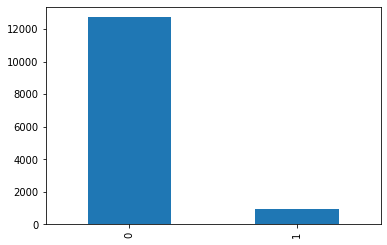

In [8]:

# visualize the distribution of y_train data
import matplotlib.pyplot as plt
ys = pd.Series(y_train)
ys.value_counts().plot(kind='bar')
plt.show()

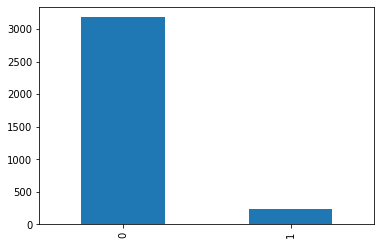

In [9]:
# test data
ys2 = pd.Series(y_test)
ys2.value_counts().plot(kind='bar')
plt.show()

**Text representation**

In [68]:
# convert tweets to matrix of word counts and remove stop words
from sklearn.feature_extraction.text import CountVectorizer

countvec = CountVectorizer(stop_words='english')

# normalise count matrix to decrease the effect of word frequencies
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()

# vectorize and transform train and test data
train_transformed = tfidf.fit_transform(countvec.fit_transform(X_train))
test_transformed = tfidf.transform(countvec.transform(X_test))

print(train_transformed.shape)
print(test_transformed.shape)

(13696, 19552)
(3424, 19552)


### 1. Logistic Regression Model

In [69]:
# course notes uses the 'liblinear' solver however sklearn uses the 'lbfgs' solver as default
log_reg = LogisticRegression(solver='lbfgs', random_state=691, class_weight='balanced')

# fit
log_reg.fit(train_transformed, y_train)
y_pred = log_reg.predict(test_transformed)

# confusion matrix
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
mat

array([[2908,  274],
       [  73,  169]])

In [70]:
# print results
print(f"Logistic Regression:")
print(f"AUC: {roc_auc_score(y_test, y_pred)}")  #0.806
print(f"Precision: {precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)[0]:.2f}") # 0.38
print(f"Recall: {precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)[1]:.2f}") # 0.70
print(f"F1 Score: {precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)[2]:.2f}") # 0.49


Logistic Regression:
AUC: 0.8061188711294419
Precision: 0.38
Recall: 0.70
F1 Score: 0.49


### 2. SVM

In [71]:
# standard SVM classifier with TF-IDF features
# linear kernel
sv_m = SVC(kernel='linear', class_weight='balanced', random_state=691)
# fit
sv_m.fit(train_transformed, y_train)
y_pred_sv = sv_m.predict(test_transformed)

In [72]:
# print results
print(f"SVM:")
print(f"AUC: {roc_auc_score(y_test, y_pred_sv)}")
print(f"Precision: {precision_recall_fscore_support(y_test, y_pred_sv, average='binary', pos_label=1)[0]:.2f}")
print(f"Recall: {precision_recall_fscore_support(y_test, y_pred_sv, average='binary', pos_label=1)[1]:.2f}")
print(f"F1 Score: {precision_recall_fscore_support(y_test, y_pred_sv, average='binary', pos_label=1)[2]:.2f}")

SVM:
AUC: 0.7717507051545107
Precision: 0.47
Recall: 0.60
F1 Score: 0.52


In [96]:
# SVM with grid search
# define the parameter grid
param_grid = {'kernel':['linear'], 'C' : [0.1, 1, 10, 100], 'gamma': [1, .01, 'auto', 'scale']}
estimator = SVC(class_weight='balanced', random_state=691)
clf = GridSearchCV(estimator, param_grid, cv=5)
# fit
clf.fit(train_transformed, y_train)
y_pred_gs = clf.predict(test_transformed)

In [97]:
confusion_matrix(y_test, y_pred_gs)

array([[3068,  114],
       [ 134,  108]])

In [98]:
print(f"SVM with grid search + 5 cv:")
print(metrics.classification_report(y_test, y_pred_gs))

SVM with grid search + 5 cv:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3182
           1       0.49      0.45      0.47       242

    accuracy                           0.93      3424
   macro avg       0.72      0.71      0.71      3424
weighted avg       0.92      0.93      0.93      3424



### 3. SVM with pre-trained GloVe
Transfer learning  
Source for [GloVe Twitter](https://nlp.stanford.edu/projects/glove/)  



In [ ]:
# GloVe Twitter embeddings - 100-dimensional embeddings for each word
# 1. convert GloVe format to word2vec format
from gensim.scripts.glove2word2vec import glove2word2vec
# note: fill too large for GH
# glove_input_file = 'DSCI691-GRP-PICKLE_RICK/Project/glove.twitter.27B.100d.txt'
# word2vec_output_file = 'DSCI691-GRP-PICKLE_RICK/Project/glove.twitter.27B.100d.txt.word2vec'
# glove2word2vec(glove_input_file, word2vec_output_file) 

In [31]:
# 2. build a baseline word2vec model
# load GloVe word vectors
filepath = '../../../Drexel/spring_22/DSCI691/DSCI691-GRP-PICKLE_RICK/Project/glove.twitter.27B/glove.twitter.27B.100d.txt.word2vec'
from gensim.models import KeyedVectors
glove_vec = KeyedVectors.load_word2vec_format(filepath, binary=False)   
glove_vec.most_similar('drug')

[('drugs', 0.8083562254905701),
 ('marijuana', 0.7322571873664856),
 ('cocaine', 0.7105314135551453),
 ('addiction', 0.6785678863525391),
 ('dealers', 0.6764513850212097),
 ('heroin', 0.6691657900810242),
 ('meth', 0.6684464812278748),
 ('dealer', 0.6547229886054993),
 ('pharmacy', 0.6478521823883057),
 ('illegal', 0.6464824080467224)]

In [33]:
# create baseline word2vec model with tweet data
# input: list of tokenized tweets
tweets_ls = []
for tweet in data['tweet']:
    tweets_ls.append(tweet.split())
    
print(tweets_ls[:5])

[['knowledge', 'is', 'powerlevaquin', 'antibiotic', 'interacts', 'with', 'the', 'medication', 'seroquel', 'and', 'can', 'cause', 'heart', 'arrthymiaslearnt', 'something', 'new', 'today', 'yes'], ['methylpred', 'glatiramer', 'acetate', 'interferon', 'alpha', 'n', 'beta', 'baclofen', 'natalizumabwhat', 'am', 'i', 'thinking'], ['cymbalta', 'can', 'help'], ['I', 'dont', 'think', 'Imodium', 'works', 'Full', 'stop', 'allegedly'], ['Meanwhile', 'all', 'I', 'get', 'is', 'flavorless', 'gelatin', 'lamotrigine', 'Fuck', 'This']]


In [39]:
# Apply word2vec transformation from GloVe pre-trained word embedding
import gensim.models as gm
# `workers` is the number of cores to use and does not work without Cython
import Cython
base_model = gm.Word2Vec(tweets_ls, vector_size=200, min_count=1, workers=4)
# ran in 1.4 seconds
base_model.build_vocab(tweets_ls)
total = base_model.corpus_count
total

17120

In [35]:
base_model.epochs

5

**Training**

In [38]:
# retrain base_model with GloVe vocaublary and starting weights
base_model.build_vocab([glove_vec.index_to_key], update=True)
# train on tweets
base_model.train(tweets_ls, total_examples=total, epochs=base_model.epochs)
# set of word vectors with glove weights and trained on tweets
base_model_wv = base_model.wv
base_model_wv.most_similar('drug')

# this looks worse than the glove model

[('of', 0.9951425194740295),
 ('in', 0.995005190372467),
 ('at', 0.9937447905540466),
 ('injection', 0.9935187101364136),
 ('returns', 0.9928048253059387),
 ('diazepam', 0.9920201897621155),
 ('18885205202', 0.9917005300521851),
 ('next', 0.991690993309021),
 ('shape', 0.9910983443260193),
 ('Reuters', 0.9903740882873535)]

In [ ]:
# function to transform tweets to word2vec vectors
# accounts for dimensionality of vectors - if word not in base_model_wv, use 0 vector
# uses the mean of all word vectors in tweet
def tweet_to_wv(tweets, theModel):
    # model = theModel
    tweet_wv = []
    for tweet in tweets:
        tweet_vec = np.zeros(200)
        for word in tweet:
            if word in theModel.index_to_key:
                tweet_vec += theModel[word]
            else:
                tweet_vec += np.zeros(200)
        tweet_vec /= len(tweet)
        tweet_wv.append(tweet_vec)
    return tweet_wv

# transform train and test data
train_wv = tweet_to_wv(X_train, base_model_wv)
test_wv = tweet_to_wv(X_test, base_model_wv)

In [ ]:
# SVM with model trained on tweets
# linear kernel
svm_wv = SVC(kernel='linear', class_weight='balanced', random_state=691)
# fit
svm_wv.fit(train_wv, y_train)
y_pred_wv = svm_wv.predict(test_wv)

In [ ]:
# save model
import pickle
# filename = '../data/svm_wv.sav'
# pickle.dump(svm_wv, open(filename, 'wb'))
# open model
pickle.load(open('../data/svm_wv.sav', 'rb'))
# print metrics
print(f"SVM with word2vec features:")
print(metrics.classification_report(y_test, y_pred_wv))

**Using GloVe v.2**  
Just expand `base_model` vocab with glove

In [40]:
# try without training on tweets
base_model2 = gm.Word2Vec(tweets_ls, vector_size=200, min_count=1, workers=4)
# ran in 1.4 seconds
base_model2.build_vocab(tweets_ls)
base_model2.build_vocab([glove_vec.index_to_key], update=True)

In [43]:
base_model_wv2 = base_model2.wv
base_model_wv2.most_similar('drug')
# still bad :(

[('thought', 0.988355278968811),
 ('video', 0.9881336688995361),
 ('biib', 0.9877603054046631),
 ('hands', 0.98773592710495),
 ('Birth', 0.987488865852356),
 ('other', 0.9874578714370728),
 ('lithium', 0.987389326095581),
 ('card', 0.9873044490814209),
 ('tenofovir', 0.9871808886528015),
 ('easy', 0.9870908260345459)]

In [ ]:
# transform train and test data
train_wv2 = tweet_to_wv(X_train, base_model_wv2)
test_wv2 = tweet_to_wv(X_test, base_model_wv2)

In [ ]:
# SVM with model trained on tweets
# linear kernel
svm_wv2 = SVC(kernel='linear', class_weight='balanced', random_state=691)
# fit
svm_wv2.fit(train_wv2, y_train)
y_pred_wv2 = svm_wv.predict(test_wv2)

In [ ]:
print(f"SVM with word2vec features but no training on tweets:")
print(metrics.classification_report(y_test, y_pred_wv2))

**Using GloVe v.3**  
Foregoing `base_model` all together and just using glove_vec out of the box to transform tweets

In [47]:
# this function only looks at glove vectors

# transform train and test data ~ 1.5hr
train_glove = tweet_to_wv(X_train, glove_vec)
test_glove = tweet_to_wv(X_test, glove_vec)

In [ ]:
# SVM with model trained on tweets
# linear kernel
svm_glove = SVC(kernel='linear', class_weight='balanced', random_state=691)
# fit
svm_glove.fit(train_glove, y_train)
y_pred_glove = svm_wv.predict(test_glove)

In [ ]:
# save model
# filename = '../data/svm_wv.sav'
# pickle.dump(svm_wv, open(filename, 'wb'))
# open model
# pickle.load(open('../data/svm_wv.sav', 'rb'))
# print metrics
print(f"SVM with glove features:")
print(metrics.classification_report(y_test, y_pred_glove))

In [50]:
# SVM with model using just glove vectors
# linear kernel
svm_wv = SVC(kernel='linear', class_weight='balanced', random_state=691)
# fit
svm_wv.fit(train_wv2, y_train)
y_pred_wv2 = svm_wv.predict(test_wv2)

*SVM classifier with rbf kernel*

In [ ]:
svm_wv_rbf = SVC(kernel='rbf', class_weight='balanced', random_state=691)
# fit
svm_wv_rbf.fit(train_wv, y_train)
y_pred_wv_rbf = svm_wv_rbf.predict(test_wv)
# save model
filename = 'DSCI691-GRP-PICKLE_RICK/Project/svm_wv_rbf.sav'
pickle.dump(svm_wv_rbf, open(filename, 'wb'))
# print metrics
print(f"SVM with word2vec features and rbf kernel:")
print(metrics.classification_report(y_test, y_pred_wv_rbf))

*SVM classifier with rbf kernel + grid search*

In [ ]:
parameters = {
    'C' : [0.1, 1, 10],
    'gamma' : [1, 'auto', 'scale']
}
svm_wv_rbf2 = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', random_state=691), parameters, cv=5)
# fit
svm_wv_rbf2.fit(train_wv, y_train)
y_pred_wv_rbf2 = svm_wv_rbf2.predict(test_wv)
# save model
filename = 'DSCI691-GRP-PICKLE_RICK/Project/svm_wv_rbf2.sav'
pickle.dump(svm_wv_rbf2, open(filename, 'wb'))
# print metrics
print(f"SVM with word2vec features and rbf kernel and gridsearch:")
print(metrics.classification_report(y_test, y_pred_wv_rbf2))

In [52]:
parameters = {
    'C' : [0.1, 1, 10],
    'gamma' : [1, 'auto', 'scale']
}
svm_gs = GridSearchCV(SVC(kernel='linear', class_weight='balanced', random_state=691), parameters, cv=5)
# fit
svm_gs.fit(train_wv2, y_train)
y_pred_gs = svm_gs.predict(test_wv2)


In [53]:
# save model
# filename = 'DSCI691-GRP-PICKLE_RICK/Project/svm_wv_rbf2.sav'
# pickle.dump(svm_wv_rbf2, open(filename, 'wb'))
# print metrics
print(f"SVM with glove features and linear kernel and gridsearch:")
print(metrics.classification_report(y_test, y_pred_gs))

SVM with glove features and linear kernel and gridsearch:
              precision    recall  f1-score   support

           0       0.97      0.66      0.78      3182
           1       0.14      0.72      0.23       242

    accuracy                           0.66      3424
   macro avg       0.55      0.69      0.51      3424
weighted avg       0.91      0.66      0.74      3424

